# Whatsapp Message Data Analysis

### Out-line

- Introduction
- Data Retrieval & Preprocessing
- Exploratory Data Analysis
- Data Visualization
- Data Interpretation
- Summarizing the Inferences
- Conclusion

### Introduction:
Whatsapp has quickly become the world’s most popular text and voice messaging application. Specializing in cross-platform messaging with over 1.5 billion monthly active users, this makes it the most popular mobile messenger app worldwide.

I thought of various projects on which I could analyse data like - Air Quality Index or The cliched Covid-19 Data Analysis.

But I thought why not do **Data Analysis on a WhatsApp group chat** of college students and find out interesting insights about who is most active, who are ghosts (the ones who do not reply), my sleep schedule, the most used emoji, the sentiment score of each person, who swears the most, the most actives times of the day, or does the group use phones during college teaching hours?

These would be some interesting insights for sure, more for me than for you, since the people in this chat are people I know personally.

### Importing Necessary Libraries

In [144]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [145]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

- Since WhatsApp texts are multi-line, you cannot just read the file line by line and get each message that you want. Instead, you need a way to identify if a line is a new message or part of an old message. You could use regular expressions.
- While reading each line, I split it based on a comma and take the first item returned from the split() function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

In [147]:
df = rawToDf('whatsapp-chat-data.txt', '12hr')
df.sample(10)

,date_time,user,message
9411,2020-08-06 23:19:00,+91 88889 97733,Also SEO optimisation
4544,2020-04-11 20:25:00,+91 97681 67131,This message was deleted
8071,2020-06-26 13:43:00,+91 80979 84068,😂
7093,2020-06-05 18:08:00,+91 88798 05171,might be a recovery
6114,2020-05-11 20:28:00,"Kartik Soneji (TSEC, CS)","OK, I thought that this was a native program. ..."
121,2020-01-27 19:44:00,"Dheeraj Lalwani (TSEC, CS)",Something or the other So that we can build o...
7097,2020-06-05 18:09:00,+91 99693 94098,It's literally one step away from being a ROM ...
10766,2020-08-26 13:31:00,"Darshan Rander (TSEC, IT)",This message was deleted
8352,2020-07-01 17:45:00,"Dheeraj Lalwani (TSEC, CS)",🔥👍🏻💪🏻
11488,2020-09-12 14:33:00,"Sahil A (TSEC, CS-B)",Great 👍


### Pre-Processing

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


- One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an empty string.
- This can be because, the message might just contain emojis. #### To see, how many such rows are there, we can use df[df['message'] == ""].shape[0]

In [149]:
df[df['message'] == ""].shape[0]

538

In [156]:
#Adding columns for analysis and visualization

df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())
df['time'] = df['date_time'].apply(lambda x: x.time())

In [157]:
df.sample(10)

,date_time,user,message,day,month,year,date,time
3584,2020-03-21 10:11:00,+91 88305 26885,,Sat,Mar,2020,2020-03-21,10:11:00
12406,2020-09-17 23:54:00,"Darshan Rander (TSEC, IT)",Damn.,Thu,Sep,2020,2020-09-17,23:54:00
76,2020-01-26 18:06:00,group_notification,+91 81696 22410 joined using this group's invi...,Sun,Jan,2020,2020-01-26,18:06:00
4000,2020-03-25 12:19:00,"Saurav Upoor (TSEC CS, SE)",Hmm,Wed,Mar,2020,2020-03-25,12:19:00
10982,2020-08-28 15:17:00,"Darshan Rander (TSEC, IT)",@917506412914 kya likha tha?🙄🙄,Fri,Aug,2020,2020-08-28,15:17:00
8823,2020-07-11 13:04:00,+91 98333 66146,😂😂,Sat,Jul,2020,2020-07-11,13:04:00
2362,2020-02-28 08:09:00,"Darshan Rander (TSEC, IT)",<Media omitted>,Fri,Feb,2020,2020-02-28,08:09:00
4148,2020-03-28 23:33:00,+91 75078 05454,,Sat,Mar,2020,2020-03-28,23:33:00
7346,2020-06-12 23:04:00,"Dheeraj Lalwani (TSEC, CS)","I know Been there.... But, I also used an ID...",Fri,Jun,2020,2020-06-12,23:04:00
11672,2020-09-12 22:22:00,"Kartik Soneji (TSEC, CS)",C is horrible with errors.,Sat,Sep,2020,2020-09-12,22:22:00


In [158]:
analysis_df = df.groupby(["year", "month"], as_index=False, sort=[True, True])["message"].count()
analysis_df = analysis_df[~analysis_df["message"].isnull()]
analysis_df["month_year"] = analysis_df.apply(lambda x: x["month"] + " " + str(x["year"]), axis=1)

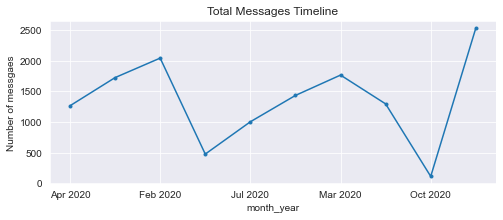

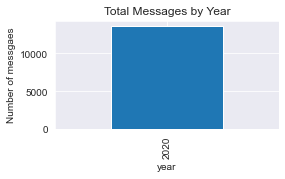

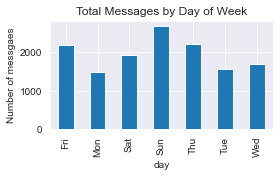

In [159]:

## plot 1
analysis_df.set_index("month_year")["message"].plot(style='.-', figsize=(8, 3))
plt.plot(title_size=20, ylabel_size=12)
plt.title('Total Messages Timeline')
plt.ylabel('Number of messgaes')
plt.show()

## plot 2
analysis_df.groupby("year")["message"].sum().plot(kind='bar', figsize=(4, 2))
plt.plot(title_size=16, ylabel_size=10, xlabel="year", xlabel_size=10, xticks_size=8, yticks_size=8)
plt.title('Total Messages by Year')
plt.ylabel('Number of messgaes')
plt.show()

## plot 3
df.groupby('day', sort=[True])["message"].count().plot(kind='bar', figsize=(4, 2))
plt.plot(title_size=15, ylabel_size=10, xlabel="Day of week", xlabel_size=10, xticks_size=8, yticks_size=8)
plt.title('Total Messages by Day of Week')
plt.ylabel('Number of messgaes')
plt.show()

### Data Analysis
1. Overall frequency of total messages on the group.

2. Top 10 most active days.

3. Top 10 active users on the group (with a twist).

4. Top 10 users most sent media.

5. Top 10 most used emojis.

6. Most active hours and days.

7. Most used words - WordCloud

### 1. Overall frequency of total messages on the group

In [160]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2020-01-24,1
1,2020-01-26,105
2,2020-01-27,90
3,2020-01-28,126
4,2020-01-29,118
...,...,...
237,2020-09-28,144
238,2020-09-29,49
239,2020-09-30,167
240,2020-10-01,91


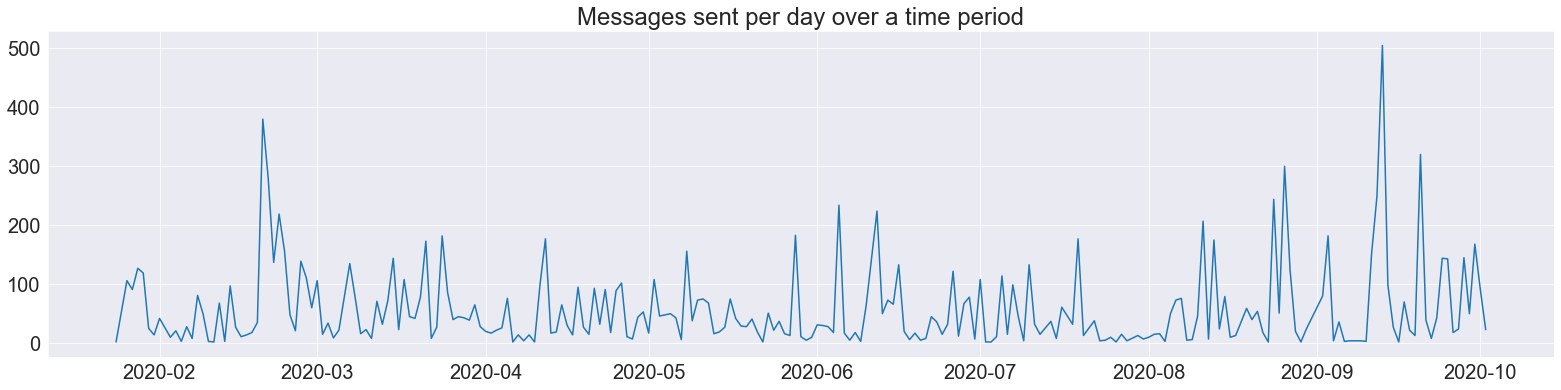

In [161]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

### 2 Top 10 most active days

In [162]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2020-09-13,504
1,2020-02-20,379
2,2020-09-20,319
3,2020-08-26,299
4,2020-02-21,278
5,2020-09-12,249
6,2020-08-24,243
7,2020-06-05,233
8,2020-06-12,223
9,2020-02-23,218


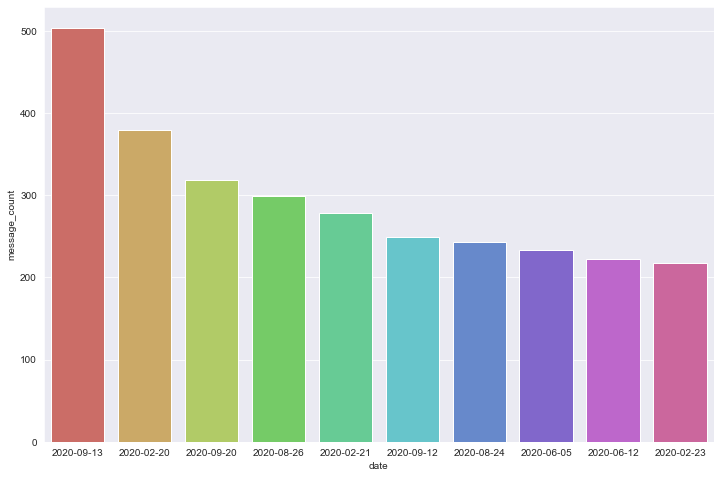

In [163]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(top10days.date, top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

### 3. Top 10 active users on the group.

In [164]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


- Total number of people who have sent at least one message on the group are 154.
- the total number of participants were 237.
- 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.

In [165]:
#pre-processing top 10 active users

df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


In [166]:
#Replacing names with initials for better visualization

top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

In [167]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

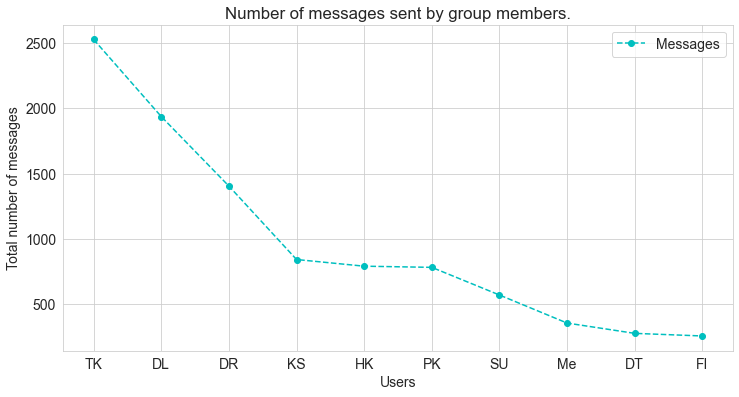

In [168]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

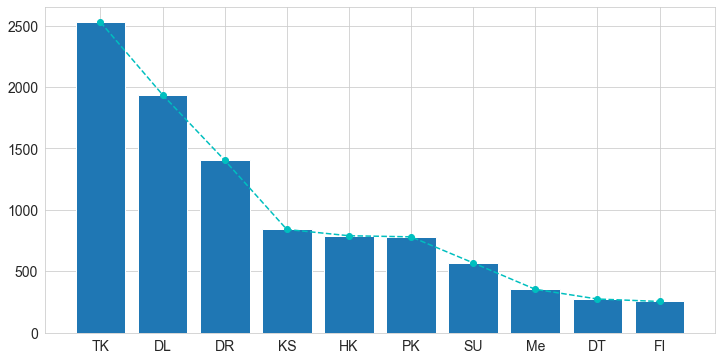

In [169]:
# Plotting a bar chart and line graph together.

# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

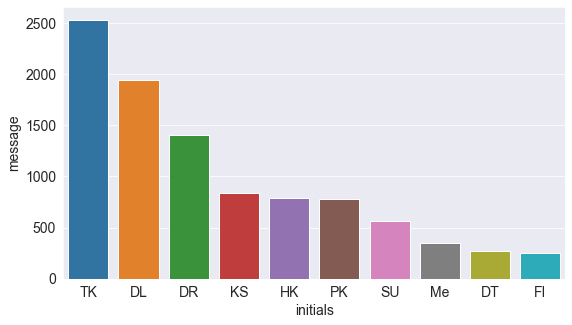

In [170]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(top10df.initials, top10df.message, data=top10df);

### Important Note
- Since almost all the plots will be comparing one person with another, I’ll assign a specific colour to each person so that it becomes easy to identify each person among multiple plots.

- I could've used seaborn's color palette but:

    - Seaborn assigns default colors itself, but i wanted the color of a certain person remains the same, no matter the plot;
    - Also, I wanted to try some different colors so I grabbed my colour palette from https://coolors.co/
- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the pallete argument in a seaborn plotting function.

### Defining a function to tackle the problem.
I'm defining the following function to maintain consistent colors for each person across all plots. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that the color of a certain person remains the same no matter the plot. This will help maintain consistency and readability amongst the many graphs I will be plotting.

In [171]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

{'TK': '#F94144',
 'DL': '#F3722C',
 'DR': '#F8961E',
 'KS': '#FDC500',
 'HK': '#F9C74F',
 'PK': '#90BE6D',
 'SU': '#43AA8B',
 'Me': '#577590',
 'DT': '#6D597A',
 'FI': '#003F88'}

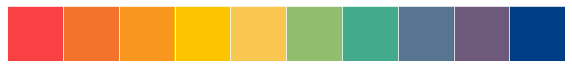

In [172]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

In [173]:
#finding the average message length of the 10 most active users of the group.
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))      

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

### Now, we will be plotting most sent messages and respective average message lengths simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using plt.subplots, which returns a set of axes that can be used for plotting.

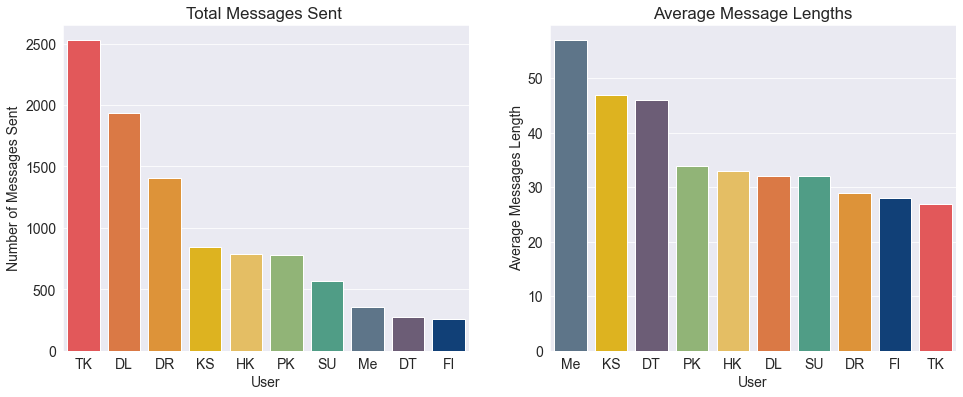

In [174]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(top10df.initials, top10df.message, data=top10df, ax = axes[0], palette=get_colors_of_certain_order(top10df.initials));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(top10df_msg.initials, top10df_msg.avg_message_length, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

### It’s really interesting to see plots like this side by side, because here comes the twist:
- Ironically, TK, the person who sent the most amount of texts (2000+), has least messages' length on average. This means this person sends broken and many WhatsApp messages in one go.

- We can see that, I send less number of messages while having a relatively longer message length, followed by KS.



### 4. Top 10 users most sent media

In [175]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

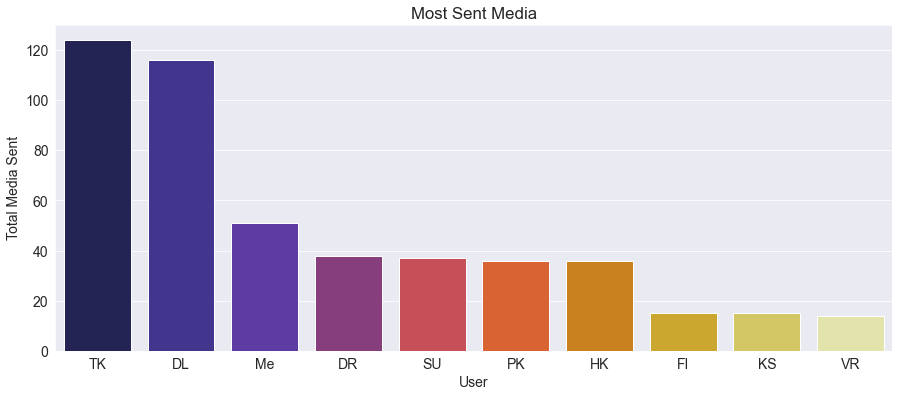

In [176]:
#Which user sends the most media?

# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(top10media.initials, top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

- TK is beating everyone by a mile, followed by DL. He also ranks the top in total messages, though last in average message length. Most dedicated contributor award goes to TK!

### 5. Top 10 most used Emojis

In [180]:
#Copy a dataset
df2 = df.copy()

#Count the number of emoji
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys()) #UNICODE_EMOJI class have a thee emoji code inside
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df2.iterrows():
    emojis_found = r.findall(row["message"]) #The findall() is a functions for regex that help to find a matches 
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1
    
    

In [181]:
#This will help to create or rendered the emoji 
emojis_df = pd.DataFrame() #The reason to use pd.dataframe is we want to put the emojis_df into the dataframe tables
emojis_df['emoji'] = [''] * 10
emojis_df['number_of_Emoji'] = [0] * 10

i = 0
for item in emoji_ctr.most_common(10):
    emojis_df.emoji[i] = item[0]
    emojis_df.number_of_Emoji[i] = int(item[1])
  
    i += 1

emojis_df

,emoji,number_of_Emoji
0,it,3789
1,es,3082
2,en,2362
3,de,2302
4,fr,346
5,pt,239
6,,0
7,,0
8,,0
9,,0


In [182]:
#This pei chart give us and ideas the overall view of which emoji use the most
fig = px.pie(emojis_df, values='number_of_Emoji', names='emoji',title='Emoji percentage used in chat group')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 6. Most active days, most active hours, most active months
###### Preprocessing

In [189]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

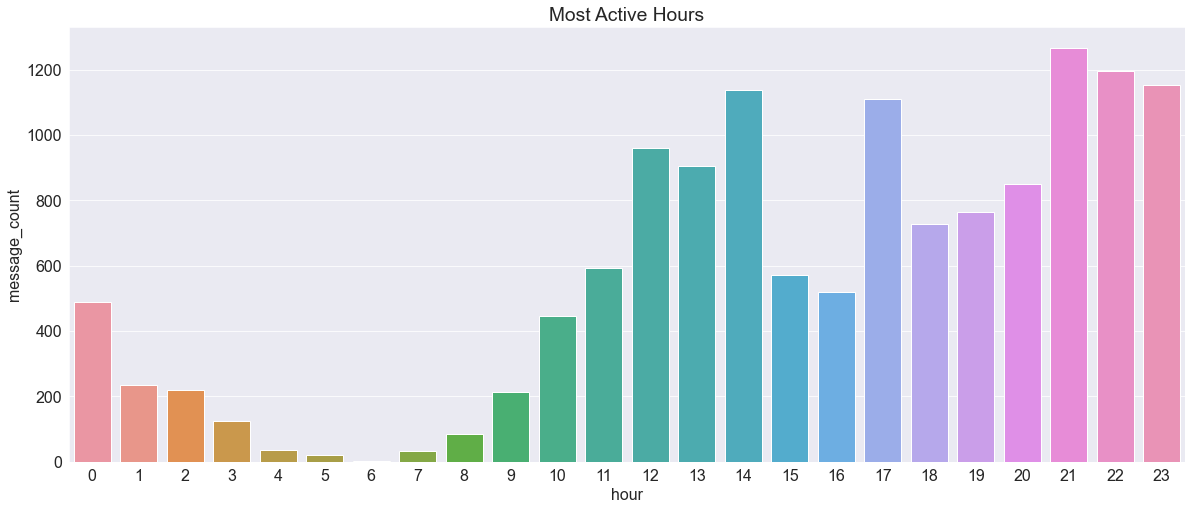

In [190]:
#Which hour of the day are most messages exchanged?

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(grouped_by_time.hour, grouped_by_time.message_count)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

###### Intrestingly, the group is most active around midnight, followed by afternoon.
### Pre-processing weekdays and months

In [191]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]

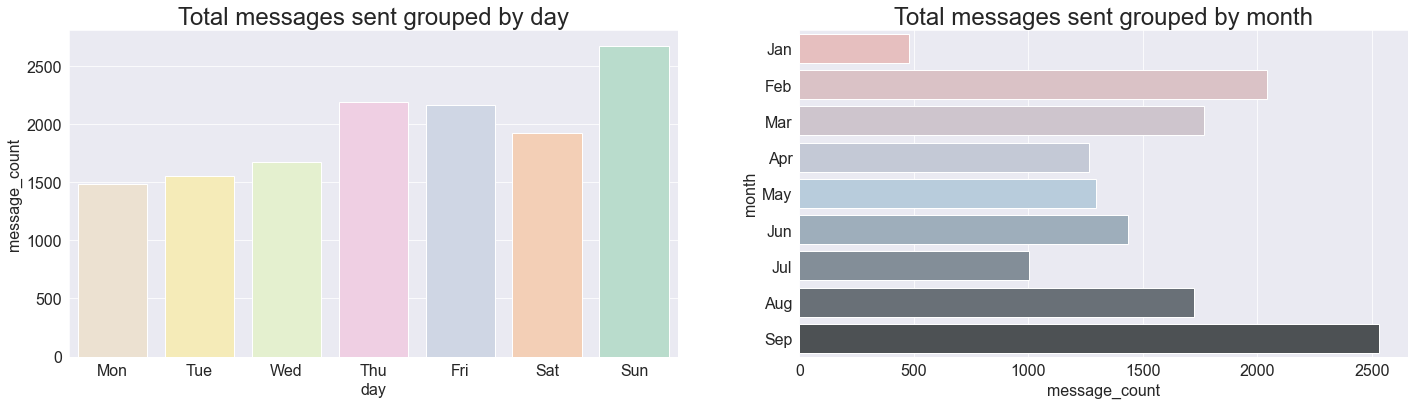

In [192]:
#plotting grouped by day and respective group by month simultaneously, to see some interesting results.

fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(grouped_by_day.day, grouped_by_day.message_count, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y = grouped_by_month.month, x=grouped_by_month.message_count, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

###### The group is most active on Sundays, and least active on Mondays (probably Monday Blues)
###### It has been recently very active, in September.
###### Now, we will plot a heatmap, combining the above to bar plots, for a better understanding!¶

2021-07-29 15:20:51,778 | INFO | utils.py:157 | _init_num_threads | NumExpr defaulting to 4 threads.


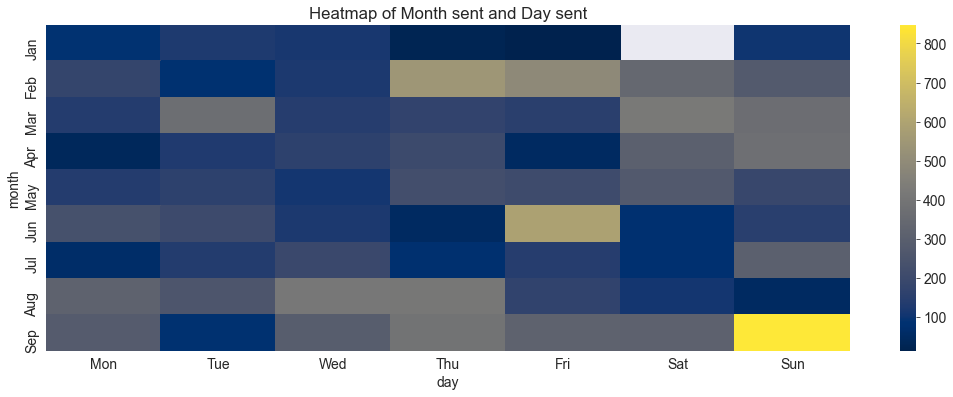

In [193]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

### Inferences
The group is more active on weekends, throughout the months.
September has the most lighter blue shades and more yellow gradients.
This gives a combined analysis, which is really helpful in real-time projects.
### 7. Most used words in the chat.
Finally, I will be ending with the most used words, using WordCloud module in Python

In [194]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words)

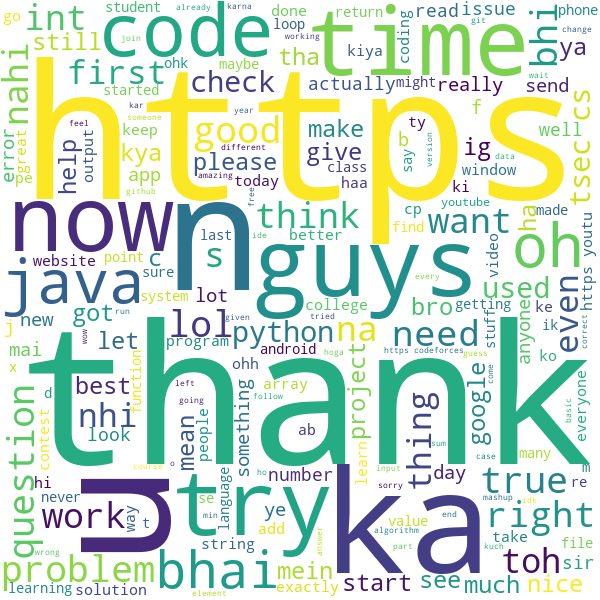

In [195]:
wordcloud.to_image()

### Conclusion
- The insights were really interesting to look at!
- We first loaded the data as a .txt file coverted it using RawtoDF function.
- Then we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!
Here is what we looked at!

1. Overall frequency of total messages on the group.

2. Top 10 most active days.

3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).

4. Top 10 users most sent media.
    - TK beats everyone by a mile!
5. Top 10 most used emojis.
    - using the emoji module!
6. Most active hours and weekdays.
    - Heatmaps of weekdays and months.
    - Most active hours, weekdays, and months.
7. Most used words - WordCloud